### Spatiotemporal Analysis of Foreshock Activity Preceding the 2025 July 29 Mw 8.8 Kamchatka Peninsula Earthquake
Beatrise (Bibi) Robinson

astatine865@gmail.com

The July 29, 2025, magnitude 8.8 earthquake on the Kamchatka Peninsula, Russia, was the largest earthquake in a seismic sequence that began 10 days earlier. The largest earthquakes before the M8.8 mainshock were a M7.4 and 3 M6.6 earthquakes on July 20. The purpose of this notebook is to conduct a spatiotemporal and magnitude-based analysis of the foreshock sequence to categorize it and determine if the sequence exhibited unusual behavior.

I've created a GitHub repository for this notebook, which is accessible at: https://github.com/seismogenesis/kamchatka-earthquake/

Further analysis of this sequence will also be available in the same repository.

We will be using data from 1 month leading up to the M8.8 mainshock (2025-06-29 23:24:52 to 2025-07-29 23:34:52)


The following code will import the necessary libraries and set up the IRIS client.

In [2]:
# Import necessary libraries
import obspy
from obspy.clients.fdsn import Client
from obspy import UTCDateTime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib
import warnings
warnings.filterwarnings('ignore')

# Set up IRIS client
client = Client("IRIS")

print("ObsPy version:", obspy.__version__)
print("Successfully connected to IRIS FDSN client")

ObsPy version: 1.4.2
Successfully connected to IRIS FDSN client


Next, we will define our study parameters. Due to the large area of this earthquake sequence, we will be defining a midpoint for our search and using a radius of 350km to ensure all relevant activity is captured. The time window for analysis will start one month before the M8.8 July 29 mainshock and end immediately before the mainshock.

In [3]:
# Sequence center coordinates
sequence_center_lat = 51.890
sequence_center_lon = 159.763
search_radius_km = 350.0

mainshock_time = UTCDateTime("2025-07-29T23:24:52") # M8.8 mainshock

# Time windows for analysis
# 1 month before mainshock
study_start = mainshock_time - (30 * 24 * 3600)  # 30 days before
study_end = mainshock_time

print(f"Mainshock time: {mainshock_time}")
print(f"Study period: {study_start} to {study_end}")
print(f"Search centered at: {sequence_center_lat}°N, {sequence_center_lon}°E")
print(f"Search radius: {search_radius_km}km")

Mainshock time: 2025-07-29T23:24:52.000000Z
Study period: 2025-06-29T23:24:52.000000Z to 2025-07-29T23:24:52.000000Z
Search centered at: 51.89°N, 159.763°E
Search radius: 350.0km


### Data Request
Method to request the data from IRIS using above parameters.

In [4]:
def get_earthquake_catalog(client, starttime, endtime, latitude, longitude, 
                          maxradius_km, minmagnitude=2.0):
    
    try: # try-catch for search
        print(f"Requesting events from {starttime} to {endtime}")
        print(f"Magnitude threshold: M{minmagnitude}+")
        
        catalog = client.get_events(
            starttime=starttime,
            endtime=endtime,
            latitude=latitude,
            longitude=longitude,
            maxradius=maxradius_km/111.32,  # Convert km to degrees
            minmagnitude=minmagnitude,
            orderby='time'
        )
        
        print(f"Retrieved {len(catalog)} events")
        return catalog
        
    except Exception as e:
        print(f"Error retrieving catalog: {e}")
        return None

# Request the data
catalog = get_earthquake_catalog(
    client=client,
    starttime=study_start,
    endtime=study_end,
    latitude=sequence_center_lat,
    longitude=sequence_center_lon,
    maxradius_km=search_radius_km,
    minmagnitude=2.5
)

Requesting events from 2025-06-29T23:24:52.000000Z to 2025-07-29T23:24:52.000000Z
Magnitude threshold: M2.5+
Retrieved 416 events


### Convert the catalog to a Pandas DataFrame for easier analysis:

In [5]:
def catalog_to_dataframe(catalog):
    
    events_data = []
    
    for event in catalog:
        origin = event.origins[0]
        magnitude = event.magnitudes[0]
        
        events_data.append({
            'time': origin.time.datetime,
            'latitude': origin.latitude,
            'longitude': origin.longitude,
            'depth_km': origin.depth / 1000.0 if origin.depth else None,
            'magnitude': magnitude.mag
        })
    
    df = pd.DataFrame(events_data)
    df = df.sort_values('time').reset_index(drop=True)
    
    return df

# Convert to DataFrame
if catalog:
    events_df = catalog_to_dataframe(catalog)
    print(f"Dataset: {len(events_df)} events")
    print(f"Magnitude range: M{events_df['magnitude'].min():.1f} - M{events_df['magnitude'].max():.1f}")

Dataset: 416 events
Magnitude range: M4.0 - M7.4


### Map Preparation - Obtain Tectonic Plate Boundary Overlays
Next, we create a map of the earthquakes. First, we will download a tectonic plate overlay from GitHub (Fraxen, 2018) and extract the Kuril-Kamchatka trench within the extent of the region that will be mapped. The methods below will allow the overlay to be easily called later.

In [6]:
import requests
import json
from shapely.geometry import shape, LineString
import geopandas as gpd

# Download tectonic plate boundaries from GitHub
def download_tectonic_plates():
    """Download actual tectonic plate boundary data"""
    
    url = "https://raw.githubusercontent.com/fraxen/tectonicplates/master/GeoJSON/PB2002_boundaries.json"
    
    try:
        print("Downloading tectonic plate boundaries...")
        response = requests.get(url)
        response.raise_for_status()
        
        # Parse GeoJSON
        tectonic_data = response.json()
        print(f"Successfully downloaded {len(tectonic_data['features'])} tectonic boundaries")
        
        return tectonic_data
    
    except Exception as e:
        print(f"Error downloading tectonic data: {e}")
        return None

# Extract Kuril-Kamchatka trench specifically
def extract_kuril_kamchatka_trench(tectonic_data, map_extent):
    """Extract trench segments within our map area"""
    
    if tectonic_data is None:
        return None
    
    west, east, south, north = map_extent
    trench_segments = []
    
    for feature in tectonic_data['features']:
        # Look for trenches/subduction zones in our area
        geometry = feature['geometry']
        
        if geometry['type'] == 'LineString':
            coords = geometry['coordinates']
            lons = [coord[0] for coord in coords]
            lats = [coord[1] for coord in coords]
            
            # Check if this segment intersects our map area
            if (any(west <= lon <= east for lon in lons) and 
                any(south <= lat <= north for lat in lats)):
                
                # Filter coordinates to map bounds
                filtered_coords = []
                for lon, lat in zip(lons, lats):
                    if west <= lon <= east and south <= lat <= north:
                        filtered_coords.append((lon, lat))
                
                if len(filtered_coords) > 1:
                    trench_segments.append(filtered_coords)
    
    print(f"Found {len(trench_segments)} tectonic boundary segments in map area")
    return trench_segments

# Download the data
tectonic_data = download_tectonic_plates()
map_extent = [155, 167, 49, 61]
trench_segments = extract_kuril_kamchatka_trench(tectonic_data, map_extent)

Successfully downloaded 241 tectonic boundaries
Found 3 tectonic boundary segments in map area


### 2D Map of Earthquake Sequence
Next, we create a 2D map of earthquakes from our data. Map features are added using Cartopy.
We will use the tectonic plate boundaries overlay we obtained above. Earthquake colors and sizes will depend on magnitude.

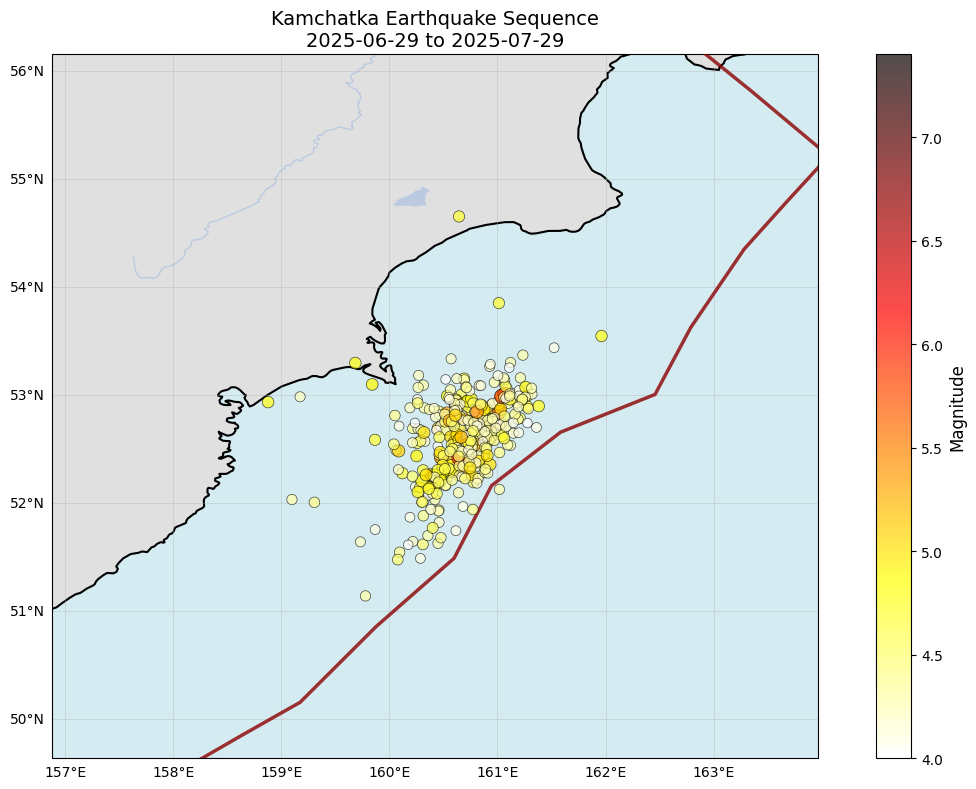

Plotted 416 earthquakes
Longitude range: 158.878° to 161.963°E
Latitude range: 51.139° to 54.650°N


In [7]:
# 2D map of earthquakes colored by magnitude
# Use a projection appropriate for the Kamchatka region
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 8))
ax = plt.axes(projection=projection)  # Create cartopy axes directly

# Add map features
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.7)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=1.5)
ax.add_feature(cfeature.BORDERS, linewidth=1)
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)

# Add tectonic plate boundaries
if trench_segments:
    for segment in trench_segments:
        if len(segment) > 1:
            lons, lats = zip(*segment)
            ax.plot(lons, lats, 'darkred', linewidth=2.5, alpha=0.8,
                   transform=ccrs.PlateCarree(), zorder=3)
    ax.plot([], [], 'darkred', linewidth=2.5, label='Tectonic Boundaries', alpha=0.8)
else:
    pass

# Add gridlines with proper lat/lon labels
gl = ax.gridlines(draw_labels=True, linewidth=0.5, alpha=0.5)
gl.top_labels = False
gl.right_labels = False

# Create scatter plot with magnitude-based coloring
scatter = ax.scatter(events_df['longitude'], events_df['latitude'], 
                    c=events_df['magnitude'], 
                    cmap='hot_r',  # Red-yellow colormap (hot colors for large magnitudes)
                    s=events_df['magnitude']**2 * 3,  # Size scales with magnitude squared
                    alpha=0.7, 
                    edgecolors='black', 
                    linewidth=0.5,
                    transform=ccrs.PlateCarree(), # Data coordinate system
                    zorder=5 ) # Plot earthquakes on top

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Magnitude', fontsize=12)

# Set map extent (zoom to area of interest)
# Calculate bounds with some padding
lon_pad = 2.0  # degrees
lat_pad = 1.5  # degrees
min_lon = events_df['longitude'].min() - lon_pad
max_lon = events_df['longitude'].max() + lon_pad
min_lat = events_df['latitude'].min() - lat_pad
max_lat = events_df['latitude'].max() + lat_pad

ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())

# Add title
ax.set_title('Kamchatka Earthquake Sequence\n'
             f'{study_start.strftime("%Y-%m-%d")} to {study_end.strftime("%Y-%m-%d")}', 
             fontsize=14)

plt.tight_layout()
plt.show()

print(f"Plotted {len(events_df)} earthquakes")
print(f"Longitude range: {events_df['longitude'].min():.3f}° to {events_df['longitude'].max():.3f}°E")
print(f"Latitude range: {events_df['latitude'].min():.3f}° to {events_df['latitude'].max():.3f}°N")

### 3D Map of Earthquake Sequence
Now we create a 3D map to visualize the depths of the earthquakes. We will use coastline data from Cartopy and filter it within the plot boundaries. 

Added coastline outlines


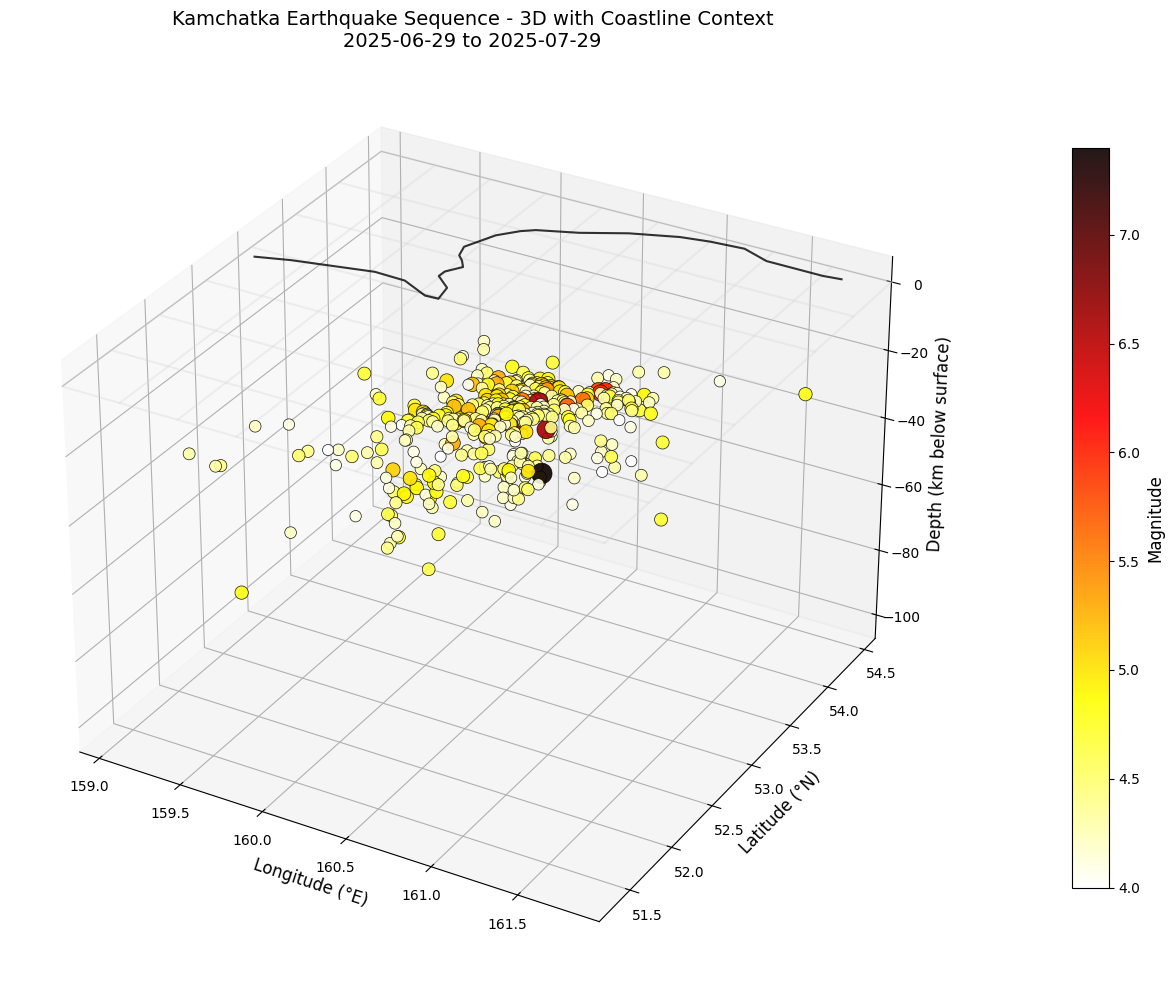

In [8]:
# 3D plot with coastline outlines - limited to plot bounds
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Get plot bounds with padding
west = events_df['longitude'].min() #- 2
east = events_df['longitude'].max() #+ 2  
south = events_df['latitude'].min() #- 2
north = events_df['latitude'].max() #+ 2

# Extract coastline data using cartopy
try:
    
    # Get coastline geometries
    coastlines = cfeature.NaturalEarthFeature('physical', 'coastline', '50m')
    
    # Plot coastlines on the z=0 plane - only within bounds
    for geom in coastlines.geometries():
        if geom.geom_type == 'LineString':
            coords = list(geom.coords)
            lons = [coord[0] for coord in coords]
            lats = [coord[1] for coord in coords]
            # Filter coordinates to only those within plot bounds
            filtered_lons = []
            filtered_lats = []
            for lon, lat in zip(lons, lats):
                if west <= lon <= east and south <= lat <= north:
                    filtered_lons.append(lon)
                    filtered_lats.append(lat)
            # Only plot if we have points within bounds
            if len(filtered_lons) > 1:
                ax.plot(filtered_lons, filtered_lats, np.zeros(len(filtered_lons)), 
                       'k-', linewidth=1.5, alpha=0.8, zorder=2)
                
        elif geom.geom_type == 'MultiLineString':
            for line in geom.geoms:
                coords = list(line.coords)
                lons = [coord[0] for coord in coords]
                lats = [coord[1] for coord in coords]
                # Filter coordinates to only those within plot bounds
                filtered_lons = []
                filtered_lats = []
                for lon, lat in zip(lons, lats):
                    if west <= lon <= east and south <= lat <= north:
                        filtered_lons.append(lon)
                        filtered_lats.append(lat)
                # Only plot if we have points within bounds
                if len(filtered_lons) > 1:
                    ax.plot(filtered_lons, filtered_lats, np.zeros(len(filtered_lons)), 
                           'k-', linewidth=1.5, alpha=0.8, zorder=2)
    
    print("Added coastline outlines")
    
except Exception as e:
    print(f"Cartopy coastlines failed: {e}")

# Add a reference grid on the base plane
lon_grid = np.linspace(west, east, 10)
lat_grid = np.linspace(south, north, 8)

# Grid lines
for lon in lon_grid:
    ax.plot([lon, lon], [south, north], [0, 0], 'lightgray', alpha=0.3, zorder=1)
for lat in lat_grid:
    ax.plot([west, east], [lat, lat], [0, 0], 'lightgray', alpha=0.3, zorder=1)

# Plot earthquakes above the coastlines
scatter = ax.scatter(events_df['longitude'], events_df['latitude'], 
                    -events_df['depth_km'],
                    c=events_df['magnitude'], 
                    cmap='hot_r',
                    s=events_df['magnitude']**2 * 4,
                    alpha=0.9,
                    edgecolors='black',
                    linewidth=0.5,
                    zorder=5)

# Set plot limits to our extended bounds
ax.set_xlim(west, east)
ax.set_ylim(south, north)

ax.set_xlabel('Longitude (°E)', fontsize=12)
ax.set_ylabel('Latitude (°N)', fontsize=12)
ax.set_zlabel('Depth (km below surface)', fontsize=12)
ax.set_title('Kamchatka Earthquake Sequence - 3D with Coastline Context\n'
                f'{study_start.strftime("%Y-%m-%d")} to {study_end.strftime("%Y-%m-%d")}', fontsize=14)

cbar = plt.colorbar(scatter, shrink=0.8, pad=0.1)
cbar.set_label('Magnitude', fontsize=12)

plt.tight_layout()
plt.show()

The range of seismicity is consistent with the Kuril-Kamchatka trench. Most seismic activity occurs at a similar depth. To better define any clustering, we will plot earthquake count, magnitude, and depth with respect to time.

### Earthquake Count Over Time
Below, we plot the earthquake count per day for every day in our study period. We will be using a histogram. The time of the mainshock will be marked for reference. If a bin has 10 or more earthquakes, the respective bar will be colored orange. We will add a box to the plot displaying statistics.

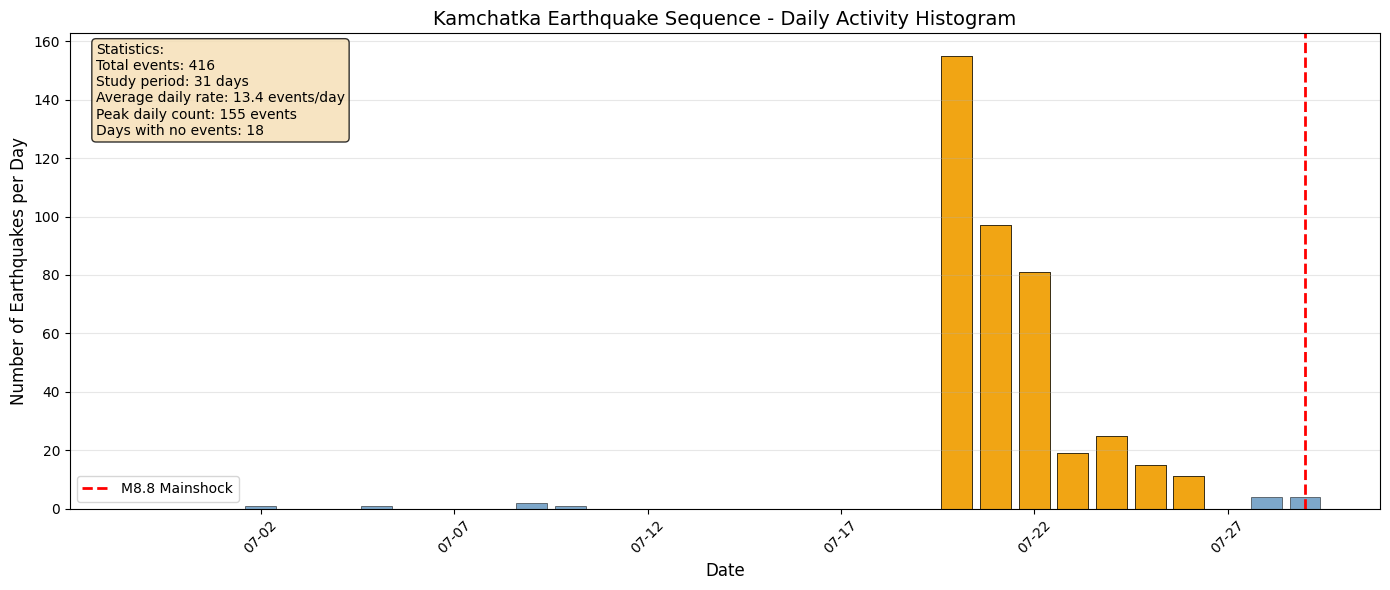

Daily activity summary:
Days with no earthquakes: 18
Days with 1-5 earthquakes: 6
Days with 6-15 earthquakes: 2
Days with 15+ earthquakes: 6


In [8]:
# Histogram of earthquake count by day
# Create date range covering the full study period
date_range = pd.date_range(start=study_start.datetime.date(), 
                          end=study_end.datetime.date(), 
                          freq='D')

# Count events per day
events_df['date'] = pd.to_datetime(events_df['time']).dt.date
daily_counts = events_df.groupby('date').size().reindex(date_range.date, fill_value=0)

fig, ax = plt.subplots(figsize=(14, 6))

# Create histogram-style bar plot
bars = ax.bar(daily_counts.index, daily_counts.values, 
              width=0.8, alpha=0.7, color='steelblue', edgecolor='black', linewidth=0.5)

# Highlight days with significant activity
high_activity = daily_counts[daily_counts >= 10]  # Days with 10+ earthquakes
for date, count in high_activity.items():
    ax.bar(date, count, width=0.8, alpha=0.9, color='orange', 
           edgecolor='black', linewidth=0.5)

# Mark the mainshock time
ax.axvline(mainshock_time.datetime.date(), color='red', linestyle='--', 
           linewidth=2, label='M8.8 Mainshock')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Number of Earthquakes per Day', fontsize=12)
ax.set_title('Kamchatka Earthquake Sequence - Daily Activity Histogram', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)

# Add statistics text box
stats_text = f"""Statistics:
Total events: {len(events_df)}
Study period: {len(date_range)} days
Average daily rate: {len(events_df)/len(date_range):.1f} events/day
Peak daily count: {daily_counts.max()} events
Days with no events: {sum(daily_counts == 0)}"""

ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()

print(f"Daily activity summary:")
print(f"Days with no earthquakes: {sum(daily_counts == 0)}")
print(f"Days with 1-5 earthquakes: {sum((daily_counts >= 1) & (daily_counts <= 5))}")
print(f"Days with 6-15 earthquakes: {sum((daily_counts >= 6) & (daily_counts <= 15))}")
print(f"Days with 15+ earthquakes: {sum(daily_counts >= 15)}")

We note that seismicity following the sequence on July 20 has decayed almost to background levels immediately before the mainshock, though it remains slightly elevated.

### Magnitude Evolution
We will plot each earthquake by its magnitude and time to create a visualization of how the magnitude range evolves as the sequence progresses. Earthquakes are colored by magnitude. We add an orange dashed line at magnitude 6.0, and a red dashed line at magnitude 7.0 for reference. The time of the M8.8 mainshock is marked using a vertical red dashed line.

Events at and above magnitude 6.0 will also be printed.

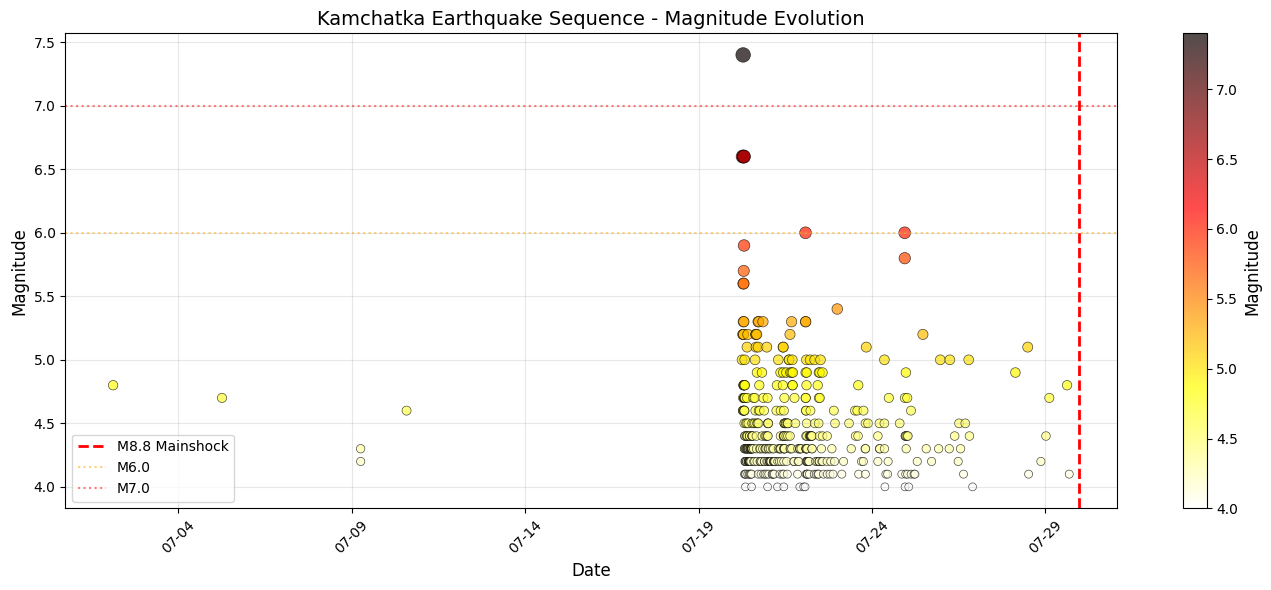

Events M6.0+: 6
Large events (M6.0+):
  M6.6 on 2025-07-20 06:28:17
  M7.4 on 2025-07-20 06:49:04
  M6.6 on 2025-07-20 07:07:42
  M6.6 on 2025-07-20 07:23:00
  M6.0 on 2025-07-22 01:59:28
  M6.0 on 2025-07-24 22:37:26


In [9]:
# Time series of earthquake magnitudes
fig, ax = plt.subplots(figsize=(14, 6))

# Plot magnitude vs time
scatter = ax.scatter(events_df['time'], events_df['magnitude'], 
                    c=events_df['magnitude'], 
                    cmap='hot_r',
                    s=events_df['magnitude']**2 * 2,
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Magnitude', fontsize=12)

# Mark the mainshock time
ax.axvline(mainshock_time.datetime, color='red', linestyle='--', 
           linewidth=2, label='M8.8 Mainshock')

# Horizontal lines for key magnitude thresholds
ax.axhline(6.0, color='orange', linestyle=':', alpha=0.5, label='M6.0')
ax.axhline(7.0, color='red', linestyle=':', alpha=0.5, label='M7.0')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Magnitude', fontsize=12)
ax.set_title('Kamchatka Earthquake Sequence - Magnitude Evolution', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print some statistics
large_events = events_df[events_df['magnitude'] >= 6.0]
print(f"Events M6.0+: {len(large_events)}")
if len(large_events) > 0:
    print("Large events (M6.0+):")
    for idx, event in large_events.iterrows():
        print(f"  M{event['magnitude']:.1f} on {event['time'].strftime('%Y-%m-%d %H:%M:%S')}")

We note that all magnitude 6.0+ events occur between July 20 and July 24. The sequence remains slightly elevated at the time of the mainshock, though we note that no earthquakes are plotted for July 27. Further analysis will be required to categorize the behavior of this sequence in more detail.

### Depth Evolution
Though we plotted a 3D map earlier, we will create a graph displaying how the depth of seismicity evolves for more detailed analysis. The earthquakes will be colored by magnitude. We invert the y-axis to display the shallowest depths at the top. We will print statistics below the graph. Dashed lines are plotted at 30 and 60 km, and at the time of the mainshock for reference.

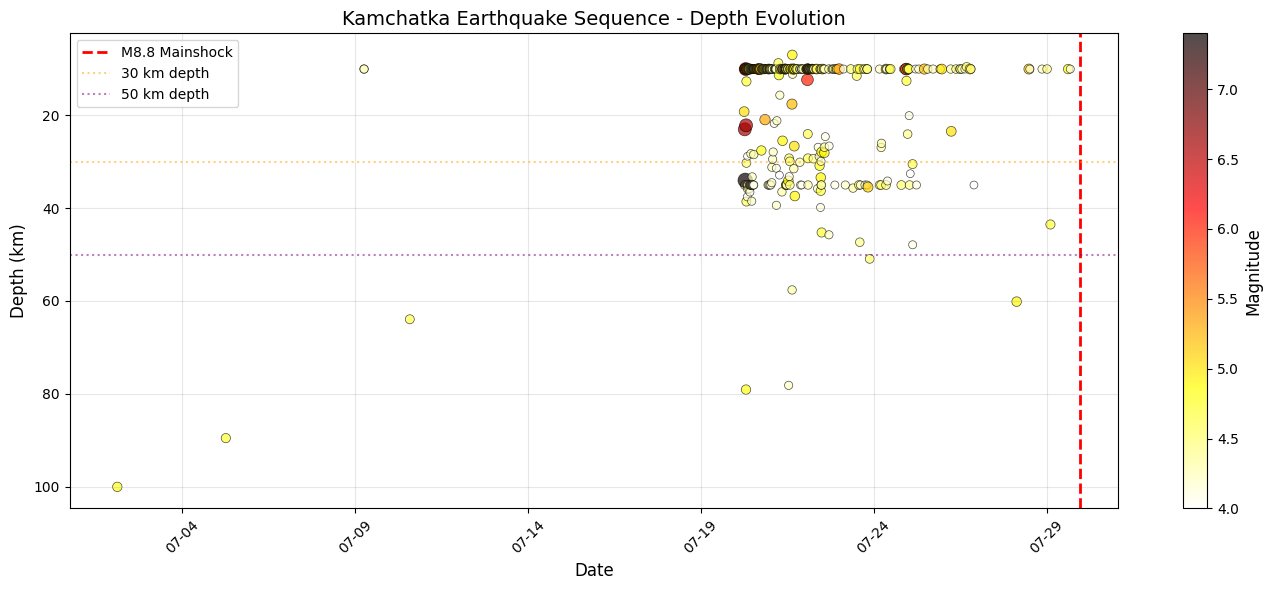

Depth statistics:
Shallowest: 7.0 km
Deepest: 100.1 km
Median depth: 10.0 km
Mean depth: 17.3 km
Events ≤20 km depth: 298 (71.6%)


In [9]:
# Depth evolution over time
fig, ax = plt.subplots(figsize=(14, 6))

# Plot depth vs time, colored by magnitude
scatter = ax.scatter(events_df['time'], events_df['depth_km'], 
                    c=events_df['magnitude'], 
                    cmap='hot_r',
                    s=events_df['magnitude']**2 * 2,
                    alpha=0.7,
                    edgecolors='black',
                    linewidth=0.5)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Magnitude', fontsize=12)

# Mark the mainshock time
ax.axvline(mainshock_time.datetime, color='red', linestyle='--', 
           linewidth=2, label='M8.8 Mainshock')

# Mark key depth levels
ax.axhline(30, color='orange', linestyle=':', alpha=0.5, label='30 km depth')
ax.axhline(50, color='purple', linestyle=':', alpha=0.5, label='50 km depth')

# Formatting
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Depth (km)', fontsize=12)
ax.set_title('Kamchatka Earthquake Sequence - Depth Evolution', fontsize=14)
ax.grid(True, alpha=0.3)
ax.legend()
ax.invert_yaxis()  # Shallow depths at top

# Format x-axis dates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
ax.xaxis.set_major_locator(mdates.DayLocator(interval=5))
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Print depth statistics
print(f"Depth statistics:")
print(f"Shallowest: {events_df['depth_km'].min():.1f} km")
print(f"Deepest: {events_df['depth_km'].max():.1f} km")
print(f"Median depth: {events_df['depth_km'].median():.1f} km")
print(f"Mean depth: {events_df['depth_km'].mean():.1f} km")
shallow_events = events_df[events_df['depth_km'] <= 20]
print(f"Events ≤20 km depth: {len(shallow_events)} ({len(shallow_events)/len(events_df)*100:.1f}%)")

We note that most events occur at depths between 10-40km, with most events occurring at depths around 10km. There appear to be two main depth clusters, at ~10km and ~35km, with the largest event (M7.4) occurring at a depth of around 35km.

### Animation Displaying Sequence Evolution
Now, we will create an animation to display the evolution of seismicity in our study period. We will color earthquakes by depth, and add a star to indicate the location and depth of the M8.8 mainshock. We will use 12-hour-long bins for each frame, and display the time of each frame.

In [12]:
# Create animation of earthquake sequence
matplotlib.rcParams['animation.embed_limit'] = 50  # Increase size limit

# M8.8 mainshock parameters
mainshock_lat = 52.498
mainshock_lon = 160.264
mainshock_depth = 35.0

# Prepare animation data
events_df_sorted = events_df.sort_values('time').copy()
events_df_sorted['time_pd'] = pd.to_datetime(events_df_sorted['time'])

start_time = events_df_sorted['time_pd'].min()
end_time = events_df_sorted['time_pd'].max()

# Create time bins (every 12 hours for smooth but not too many frames)
time_bins = pd.date_range(start=start_time, end=end_time, freq='12H')

# Set up the figure
fig, ax = plt.subplots(figsize=(12, 8), subplot_kw={'projection': ccrs.PlateCarree()})

# Set map extent
ax.set_extent(map_extent, crs=ccrs.PlateCarree())

# Add static map features
ax.add_feature(cfeature.LAND, color='lightgray', alpha=0.7)
ax.add_feature(cfeature.OCEAN, color='lightblue', alpha=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=1.5)
ax.add_feature(cfeature.BORDERS, linewidth=1, alpha=0.5)

# Add tectonic plate boundaries
if trench_segments:
    for segment in trench_segments:
        if len(segment) > 1:
            lons, lats = zip(*segment)
            ax.plot(lons, lats, 'darkred', linewidth=2.5, alpha=0.8,
                   transform=ccrs.PlateCarree(), zorder=3)
    ax.plot([], [], 'darkred', linewidth=2.5, label='Tectonic Boundaries', alpha=0.8)
else:
    pass

# Initialize scatter plot
scat = ax.scatter([], [], c=[], s=[], cmap='viridis_r', alpha=0.8,
                 edgecolors='black', linewidth=0.5, vmin=0, vmax=100,
                 transform=ccrs.PlateCarree(), zorder=4)

# Initialize mainshock marker
mainshock_star = ax.scatter([], [], s=400, marker='*', c='red', 
                           edgecolors='darkred', linewidth=2,
                           transform=ccrs.PlateCarree(), zorder=6)

# Add colorbar
cbar = plt.colorbar(scat, ax=ax, orientation='horizontal', shrink=0.6, pad=0.08)
cbar.set_label('Depth (km)', fontsize=12)

# Add title
title = ax.set_title('Kamchatka Sequence Evolution - Loading...', fontsize=14)
ax.legend(loc='upper left')

# Animation function
def animate(frame):
    if frame >= len(time_bins):
        return scat, mainshock_star, title
        
    current_time = time_bins[frame]
    
    # Get events up to current time
    mask = events_df_sorted['time_pd'] <= current_time
    current_events = events_df_sorted[mask]
    
    if len(current_events) > 0:
        # Update earthquake scatter
        points = np.column_stack([current_events['longitude'].values, 
                                current_events['latitude'].values])
        scat.set_offsets(points)
        scat.set_array(current_events['depth_km'].values)
        scat.set_sizes(current_events['magnitude'].values**2 * 3)
        
        # Show mainshock
        mainshock_star.set_offsets([[mainshock_lon, mainshock_lat]])
        # Color star by its depth
        mainshock_color_val = mainshock_depth / 100.0  # Normalize for colormap
        mainshock_star.set_color(plt.cm.viridis_r(mainshock_color_val))
    else:
        scat.set_offsets(np.empty((0, 2)))
        scat.set_array(np.array([]))
        scat.set_sizes(np.array([]))
        mainshock_star.set_offsets(np.empty((0, 2)))
    
    # Update title
    title.set_text(f'Kamchatka Sequence Evolution\n'
                  f'{current_time.strftime("%Y-%m-%d %H:%M")} UTC | '
                  f'{len(current_events)} events | '
                  f'Progress: {frame+1}/{len(time_bins)}')
    
    return scat, mainshock_star, title

# Create animation
print(f"Creating animation with {len(time_bins)} frames...")
anim = animation.FuncAnimation(fig, animate, frames=len(time_bins), 
                              interval=200, blit=False, repeat=True)

# Display animation in Jupyter notebook
plt.close()  # Close the static plot
HTML(anim.to_jshtml())  # This should show the actual animation

Creating animation with 56 frames...


In the animation, we note that the sequence starts in the general area of the mainshock, but there appears to be some level of migration over time. 

### Conclusion
We examined the activity of the Kuril-Kamchatka trench in the area of the sequence including the 2025 July 29 M8.8 Kamchatka Peninsula earthquake. Our analysis period extended from 2025-06-29 23:24:52 to 2025-07-29 23:34:52. We noted that there were 6 earthquakes above M6.0 in the week before the mainshock, though activity had decayed to levels slightly above background at the time of the mainshock. Most earthquakes occurred at a depth between 10-40km, with two prominent clusters at ~10km and ~35km. There is a possible, though loosely constrained, migration present in this sequence towards the epicenter of the mainshock. 
Further analysis will be required. Later studies will include Gutenberg-Richter Law analysis for the sequence, such as a-value and b-value evolution, moment tensor derivation for larger events in the sequence, and classifying past seismic sequences along the same area of the Kuril-Kamchatka trench for comparison. These studies will be available in the GitHub repository of this notebook at https://github.com/seismogenesis/kamchatka-earthquake/

### Data Sources and Software Citations

**Earthquake Catalog Data:**
- Incorporated Research Institutions for Seismology (IRIS) Data Management Center. (2025). IRIS FDSN Web Services. Retrieved from https://service.iris.edu/

**Tectonic Plate Boundaries:**
- Fraxen, H. (2018). An accurate and complete dataset of tectonic plate boundaries. GitHub repository: fraxen/tectonicplates. Retrieved from https://github.com/fraxen/tectonicplates
- Bird, P. (2003). An updated digital model of plate boundaries. Geochemistry, Geophysics, Geosystems, 4(3), 1027. doi:10.1029/2001GC000252

**Software Libraries:**
- Beyreuther, M., Barsch, R., Krischer, L., Megies, T., Behr, Y., & Wassermann, J. (2010). ObsPy: A Python toolbox for seismology. Seismological Research Letters, 81(3), 530-533. doi:10.1785/gssrl.81.3.530

- Met Office (2010-2023). Cartopy: A cartographic python library with matplotlib support. Exeter, Devon. Retrieved from https://scitools.org.uk/cartopy

- Hunter, J. D. (2007). Matplotlib: A 2D graphics environment. Computing in Science & Engineering, 9(3), 90-95. doi:10.1109/MCSE.2007.55

- McKinney, W. (2010). Data structures for statistical computing in Python. Proceedings of the 9th Python in Science Conference, 445, 51-56.

- Harris, C.R., Millman, K.J., van der Walt, S.J. et al. (2020). Array programming with NumPy. Nature, 585, 357-362. doi:10.1038/s41586-020-2649-2

**Geographic Data:**
- Natural Earth (2023). Free vector and raster map data. Retrieved from https://www.naturalearthdata.com/